In [827]:
# from google.colab import drive
# drive.mount('/content/drive')

# 0. Preamble

In [828]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statistics
from sklearn.linear_model import LinearRegression
import os
import sqlite3

In [829]:
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

In [830]:
data = pd.read_csv("../raw_data/global_crisis_data_country.csv", encoding='unicode_escape')
data.drop(0, inplace = True)
data.shape

(15190, 27)

In [831]:
data.rename(columns={'Banking Crisis ':'banking_crisis',
                    'Systemic Crisis':'systemic_crisis',
                    'Banking_Crisis_Notes':'notes',
                    'Currency Crises':'currency_crisis',
                    'Inflation Crises':'inflation_crisis',
                    'Gold Standard':'gold_standard',
                    'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_1',
                    'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors': 'sovereign_external_debt_2',
                    'Inflation, Annual percentages of average consumer prices':'annual_inflation'},
            inplace = True)

data['Year'] = data['Year'].astype(int)

columns_to_convert = ['banking_crisis', 'systemic_crisis', 'annual_inflation', 'currency_crisis', 'inflation_crisis']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [832]:
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')
GDP_pc.drop(columns='417485-annotations', inplace = True)
GDP_pc.rename(columns={'GDP per capita':'GDP_per_capita'}, inplace = True)

# 1. Selecting countries for global analysis

In [833]:
def create_output_df(data, code):
    ''''From the dataset GDP_per_capita, this function create a dataframe the Hodrixk-Prescott detrended output gap for a specific country code.
    '''
    df = data.loc[data['Code'] == code]
    cycle, trend = sm.tsa.filters.hpfilter(df.GDP_per_capita, lamb=1600)
    dataframe = pd.DataFrame({
    'CC3': df.Code,
    'Year' : df.Year,
    'output_gap' : round(((df.GDP_per_capita - trend)/trend)*100, 2)})
    return dataframe

def merge_datasets(dataset1, dataset2, on=['Year', 'CC3'], how='left'):
    merged_df = pd.merge(dataset1, dataset2, on=on, how=how)
    return merged_df

def concat_dataset(dataset1, dataset2, list, how):
    all_datasets = []
    for code in list:
        df = merge_datasets(dataset2[dataset2["CC3"]==code], create_output_df(dataset1, code), how = how)
        all_datasets.append(df)

    concat_dataset = pd.concat(all_datasets,ignore_index=True)
    return concat_dataset

In [874]:
countries_selected = [
                      'USA',
                    #   'FRA',
                    #   'GBR',
                    #   'ITA',
                    #   'DEU',
                    #   'CAN',
                    #   'JPN',
                    #   'ESP',
                    #   'NLD',
                    #   'DNK',
                    #   'SWE',
                    #   'BEL',
                    #   'NOR',
                    #   'PRT',
                    #   'FIN',
                    #   'AUT',
                    # #   'IND',
                    #   'BRA',
                    # #   'CAF',
                    # #   'MEX',
                    # # #   'ZWE',
                    #   'ARG',
                    # #   'CHN',
                    # #   'RUS',
                    #   'HUN',
                    #   'AUS',
                    # #   'THA',
                    # #   'GRC',
                    # #   'EGY'
                      ]

In [875]:
global_data = concat_dataset(GDP_pc, data, countries_selected, 'left')
global_data

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,sovereign_external_debt_1,sovereign_external_debt_2,Defaults_External_Notes,GDP_Weighted_default,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap
0,66.0,USA,United States,1800,0.0,NaN,0.0,0,4.462293619,NaN,...,0,0.0,NaN,0,1,2.0,1,0,0.0,13.91
1,66.0,USA,United States,1801,0.0,NaN,0.0,0,4.363001745,NaN,...,0,0.0,NaN,0,0,1.3,1,0,0.0,13.08
2,66.0,USA,United States,1802,0.0,NaN,0.0,0,4.474272931,NaN,...,0,0.0,NaN,0,0,-15.7,1,0,0.0,12.33
3,66.0,USA,United States,1803,0.0,NaN,0.0,0,4.662004662,NaN,...,0,0.0,NaN,0,0,5.4,1,0,0.0,8.07
4,66.0,USA,United States,1804,0.0,NaN,0.0,0,4.528985507,NaN,...,0,0.0,NaN,0,0,4.4,1,0,0.0,5.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,66.0,USA,United States,2012,0.0,NaN,0.0,0,1.6251,NaN,...,0,0.0,NaN,0,0,2.1,1,0,0.0,-2.14
213,66.0,USA,United States,2013,0.0,NaN,0.0,0,1.6556,NaN,...,0,0.0,NaN,0,0,1.5,1,0,0.0,-2.22
214,66.0,USA,United States,2014,0.0,NaN,0.0,0,1.5573,NaN,...,0,0.0,NaN,0,0,1.6,1,0,0.0,-1.66
215,66.0,USA,United States,2015,NaN,NaN,0.0,0,1.4738,NaN,...,0,0.0,NaN,0,0,0.1,1,0,NaN,-0.88


In [876]:

# Checking for NaN value in annual_inflation column
not_nan_mask = ~np.isnan(global_data['annual_inflation'])

# Creating a dummy for the years with a banking crisis and no inflation crisis
global_data['banking_crisis_only'] = ((global_data['banking_crisis'] == 1) &
                                      (global_data['inflation_crisis'] != 1) &
                                      not_nan_mask)
global_data['banking_crisis_only'] = global_data['banking_crisis_only'].astype(int)
banking_crisis_year = global_data[global_data['banking_crisis_only'] == 1]['Year'].tolist() #Appending those years to a list


# Creating a dummy for the first years of crisis with a banking crisis and no inflation crisis
global_data['banking_crisis_only_first_year'] = 0

# Initialize variable to keep track of the last row where Dummy took value 1
last_dummy_1_year = None

for index, row in global_data.iterrows():
    if row['banking_crisis_only'] == 1:
        if last_dummy_1_year is None:
            global_data.at[index, 'banking_crisis_only_first_year'] = 1
        # If the current row's Dummy column is 1, check the year difference
        if (last_dummy_1_year is not None and row['Year'] - last_dummy_1_year >= 2) or (last_dummy_1_year is not None and row['Year'] - last_dummy_1_year <0):
            global_data.at[index, 'banking_crisis_only_first_year'] = 1
        # Update last_dummy_1_year
        last_dummy_1_year = row['Year']

#Create a dummy for recovery period
global_data['recovery_only'] = ((global_data['banking_crisis'] != 1) &
                                (global_data['inflation_crisis'] != 1) &
                                (global_data['systemic_crisis'] != 1) &
                                not_nan_mask)
global_data['recovery_only'] = global_data['recovery_only'].astype(int)

# # Iterate through the rows of the DataFrame
# for index, row in global_data.iterrows():
#     if row['banking_crisis_only'] == 1:
#         # If the current row's Dummy column is 1, update last_dummy_1_row
#         last_dummy_1_row = index
#     if row['banking_crisis_only'] == 1 and last_dummy_1_row is not None:
#         # Check if the difference between the current year and the last year
#         # where Dummy took value 1 is greater than 2
#         if row['Year'] - global_data.at[last_dummy_1_row, 'Year'] > 2:
#             global_data.at[index, 'banking_crisis_only_first_year'] = 1


# banking_crisis_first_year = [banking_crisis_years[0]]
# for i in range (1, len(banking_crisis_years)):
#     if banking_crisis_years[i]-banking_crisis_years[i-1] >=2 or banking_crisis_years[i]-banking_crisis_years[i-1]<0:
#         banking_crisis_first_year.append(banking_crisis_years[i])

banking_crisis_first_year = global_data[global_data['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list

print(f'In this approch, we record {len(banking_crisis_first_year)} different crisis event.')
banking_crisis_first_year

In this approch, we record 15 different crisis event.


[1814,
 1817,
 1825,
 1837,
 1841,
 1857,
 1861,
 1873,
 1884,
 1893,
 1907,
 1914,
 1929,
 1984,
 2007]

In [877]:
crisis_duration = []
current_length = 0

for banking_crisis, inflation_crisis, annual_inflation in zip(global_data['banking_crisis'], global_data['inflation_crisis'], global_data['annual_inflation']):
    if banking_crisis == 1 and inflation_crisis != 1 and not np.isnan(annual_inflation):
        current_length += 1
    elif current_length > 0:
        crisis_duration.append(current_length)
        current_length = 0

# Check if the last sequence extends to the end of the dataset
if current_length > 0:
    crisis_duration.append(current_length)

print(crisis_duration)
print(len(crisis_duration))

[1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 8, 4]
15


In [878]:
length_counts = {}
for length in crisis_duration:
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1

# Convert dictionary to pandas DataFrame
len_freq = pd.DataFrame(list(length_counts.items()), columns=['Length','Count'])
len_freq = len_freq.sort_values(by='Length')


# # Add a number of data points column
len_freq['Number of points'] = len_freq['Count'].sum() - len_freq['Count'].cumsum() + len_freq['Count']

# Sort DataFrame by length
len_freq.reset_index(drop=True, inplace=True)
len_freq

,Length,Count,Number of points
0,1,10,15
1,2,1,5
2,3,1,4
3,4,1,3
4,5,1,2
5,8,1,1


In [879]:
global_data.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,GDP_Weighted_default,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,banking_crisis_only_first_year,recovery_only
0,66.0,USA,United States,1800,0.0,NaN,0.0,0,4.462293619,NaN,...,0,1,2.0,1,0,0.0,13.91,0,0,1
1,66.0,USA,United States,1801,0.0,NaN,0.0,0,4.363001745,NaN,...,0,0,1.3,1,0,0.0,13.08,0,0,1
2,66.0,USA,United States,1802,0.0,NaN,0.0,0,4.474272931,NaN,...,0,0,-15.7,1,0,0.0,12.33,0,0,1
3,66.0,USA,United States,1803,0.0,NaN,0.0,0,4.662004662,NaN,...,0,0,5.4,1,0,0.0,8.07,0,0,1
4,66.0,USA,United States,1804,0.0,NaN,0.0,0,4.528985507,NaN,...,0,0,4.4,1,0,0.0,5.88,0,0,1


# 2. Extracting inflation series

In [905]:
def extract_inflation_series(data):
    ''' We want here to return the series of the inflaion rate for each first year of crisis until an inflation crisis happen or another banking crisis occurs.'''
    series = []
    current_serie = []

    for index, row in data.iterrows():
        if not pd.isna(row['annual_inflation']):
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
            if row['banking_crisis_only_first_year'] == 1:
                # Extract data during a crisis
                if index - 1 >= 0:
                    current_serie.append(data.at[index - 1, 'annual_inflation'])
                current_serie.append(row['annual_inflation'])
                for i in range(1,7):
                    if data.at[index + i, 'inflation_crisis'] == 1 or pd.isna(data.at[index + i,'annual_inflation']):
                        # data.at[index + i, 'banking_crisis_only_first_year'] == 1 or
                        break
                    current_serie.append(data.at[index + i,'annual_inflation'])
                series.append(current_serie)
                current_serie = []
    return series

In [906]:
def normalize_crisis_data(list):
    normalized_list = []
    for sublist in list:
        first_element = sublist[0]
        normalized_sublist = [round(value - first_element,2) for value in sublist]
        normalized_list.append(normalized_sublist)
    return normalized_list

In [907]:
def compute_pattern(list):
    max_length = max(len(sublist) for sublist in list)

    # Initialize an array for the average pattern
    pattern = np.zeros(max_length)

    # Iterate through each position in the pattern
    for i in range(max_length):
        # Initialize variables for the sum and length for each position
        col_sum = 0
        length = 0

        # Iterate through each sublist
        for sublist in list:
            # Check if the current sublist has a value at the current position
            if i < len(sublist):
                col_sum += sublist[i]
                length += 1

        # Calculate the mean for the current position
        mean = col_sum / length if length > 0 else 0

        # Set the mean in the average pattern array
        pattern[i] = mean


    return pattern

In [908]:
# def extract_inflation_series(data, target_year):
#     target_index = data[data['Year'] == target_year].index[0]
#     series = data.loc[target_index-1:target_index+6, 'annual_inflation']
#     return np.array(series)

# def years_xaxis(length):
#     years = []
#     for i in range (-1,length):
#         if i<0:
#             years.append(f"t{i}")
#         elif i==0:
#             years.append(f"t")
#         else:
#             years.append(f"t+{i}")
#     return years


In [909]:
inflation_series = extract_inflation_series(global_data)
len(inflation_series)

15

In [910]:
# crisis_duration

In [911]:
# norm_inflation_series = inflation_series

In [912]:
norm_inflation_series = normalize_crisis_data(inflation_series)
len(norm_inflation_series)

15

In [913]:
# inflation_series = []
# for year in banking_crisis_first_year:
#     series_for_year = extract_inflation_series(global_data, year)
#     inflation_series.append(series_for_year)
# inflation_series = np.array(inflation_series)

In [914]:
# norm_inflation_series = []
# for array in inflation_series:
#     norm_inflation_series.append(array - array[0])
# norm_inflation_series = np.array(norm_inflation_series)
# len(norm_inflation_series)

## 2.1 Inflation response to each year of crisis

10


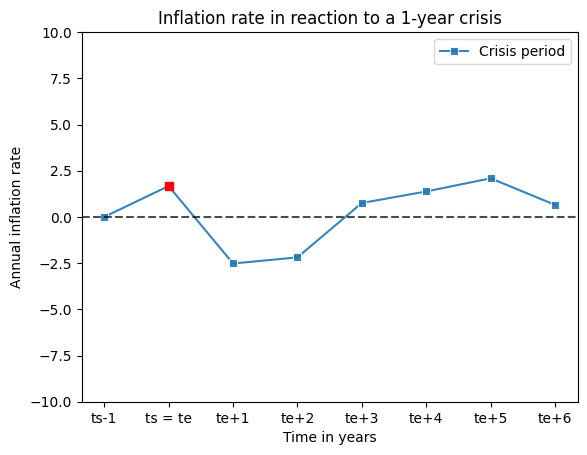

1


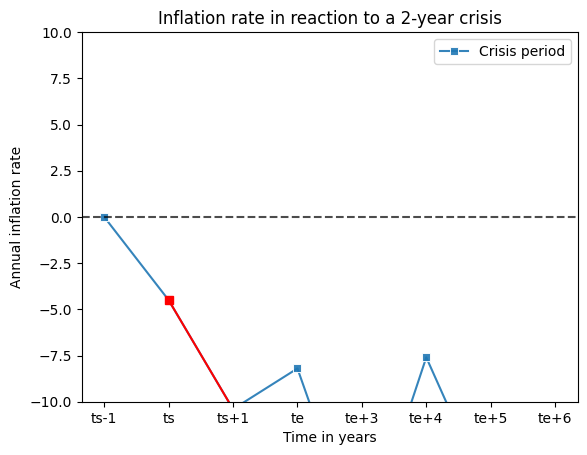

1


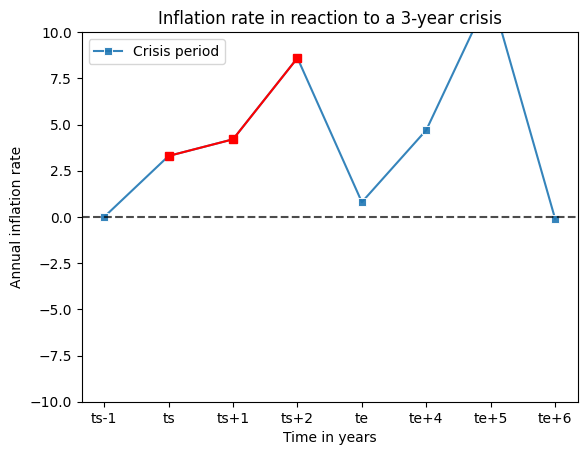

1


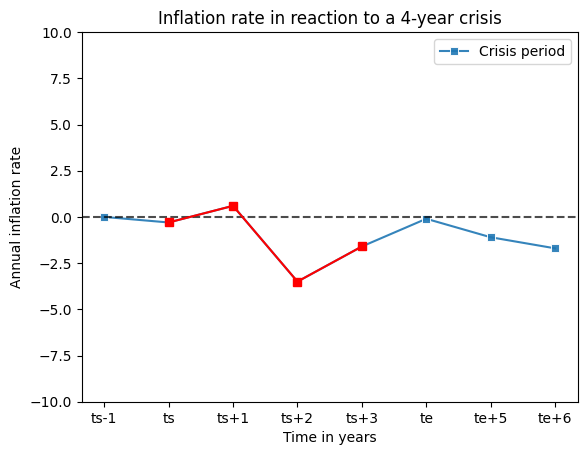

1


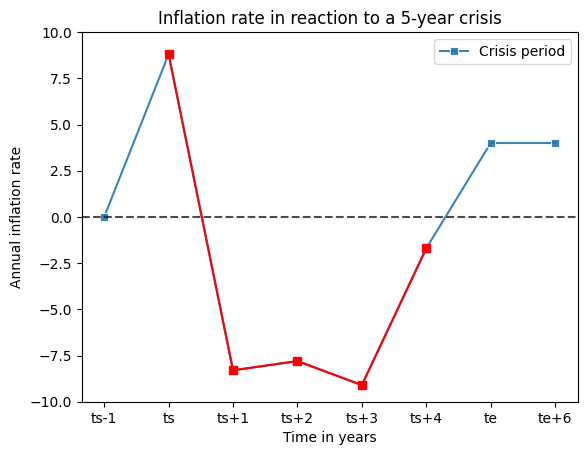

1


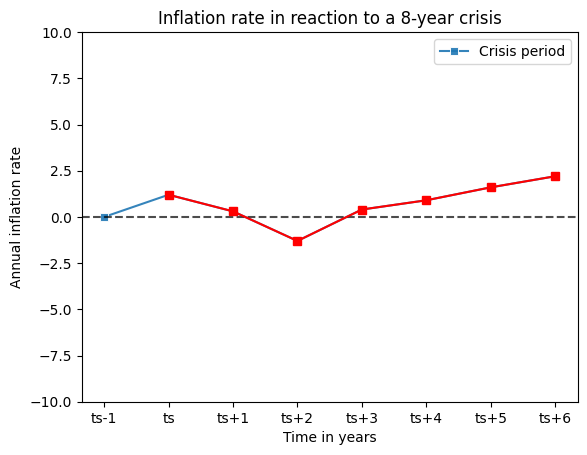

In [915]:
for i in len_freq.Length:
    series_by_crisis_length = []
    #Appending the series for single year crisis
    for j in range (0,len(norm_inflation_series)):
        if crisis_duration[j] == i:
            series_by_crisis_length.append(norm_inflation_series[j])
    print(len(series_by_crisis_length))

    average_pattern = compute_pattern(series_by_crisis_length)
    # confidence_interval = 1.96 * np.std(normalize_crisis_data(series_by_crisis_length, axis=0) / np.sqrt(series_by_crisis_length.shape[0])

    if i == 1:
        years = [f"ts{k}" if k < 0
                 else f"te+{k}" if k > 0
                 else "ts = te"
                 for k in range(-1, len(average_pattern) - 1)]
    else:
        years = [f"ts{k}" if k < 0
                 else f"ts" if k == 0
                 else f"ts+{k}" if 0 < k < i
                 else "te" if k == i
                 else f"te+{k}"
                 for k in range(-1, len(average_pattern) - 1)]

    # plt.fill_between(
    #     range(len(average_pattern)),
    #     average_pattern - confidence_interval,
    #     average_pattern + confidence_interval,
    #     color='blue',
    #     alpha=0.1, label='95% CI'
    # )

    sns.lineplot(x = years, y = average_pattern, marker = 's', label = 'Crisis period', alpha = 0.9)
    plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.7)

    plt.plot(years[1:1+i], average_pattern[1:1+i], marker='s', color='red')  # Change marker color to red for example

    plt.title(f'Inflation rate in reaction to a {i}-year crisis')


    plt.xlabel('Time in years')
    plt.ylabel('Annual inflation rate')
    plt.ylim(-10, 10)

    plt.show()

# 3. Extracting output gap series

In [916]:
global_data_inner = concat_dataset(GDP_pc, data, countries_selected, 'inner')
global_data_inner

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,sovereign_external_debt_1,sovereign_external_debt_2,Defaults_External_Notes,GDP_Weighted_default,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap
0,66.0,USA,United States,1800,0.0,NaN,0.0,0,4.462293619,NaN,...,0,0.0,NaN,0,1,2.0,1,0,0.0,13.91
1,66.0,USA,United States,1801,0.0,NaN,0.0,0,4.363001745,NaN,...,0,0.0,NaN,0,0,1.3,1,0,0.0,13.08
2,66.0,USA,United States,1802,0.0,NaN,0.0,0,4.474272931,NaN,...,0,0.0,NaN,0,0,-15.7,1,0,0.0,12.33
3,66.0,USA,United States,1803,0.0,NaN,0.0,0,4.662004662,NaN,...,0,0.0,NaN,0,0,5.4,1,0,0.0,8.07
4,66.0,USA,United States,1804,0.0,NaN,0.0,0,4.528985507,NaN,...,0,0.0,NaN,0,0,4.4,1,0,0.0,5.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,66.0,USA,United States,2012,0.0,NaN,0.0,0,1.6251,NaN,...,0,0.0,NaN,0,0,2.1,1,0,0.0,-2.14
213,66.0,USA,United States,2013,0.0,NaN,0.0,0,1.6556,NaN,...,0,0.0,NaN,0,0,1.5,1,0,0.0,-2.22
214,66.0,USA,United States,2014,0.0,NaN,0.0,0,1.5573,NaN,...,0,0.0,NaN,0,0,1.6,1,0,0.0,-1.66
215,66.0,USA,United States,2015,NaN,NaN,0.0,0,1.4738,NaN,...,0,0.0,NaN,0,0,0.1,1,0,NaN,-0.88


In [917]:

# Check if 'annual_inflation' is not NaN
not_nan_mask = ~np.isnan(global_data_inner['output_gap'])

# Creating a dummy for the years with a banking crisis and no inflation crisis
global_data_inner['banking_crisis_only'] = ((global_data_inner['banking_crisis'] == 1) &
                                            (global_data_inner['inflation_crisis'] != 1) &
                                            not_nan_mask)
global_data_inner['banking_crisis_only'] = global_data_inner['banking_crisis_only'].astype(int)

banking_crisis_year = global_data_inner[global_data_inner['banking_crisis_only'] == 1]['Year'].tolist() #Appending those years to a list

# Creating a dummy for the first years of crisis with a banking crisis and no inflation crisis
global_data_inner['banking_crisis_only_first_year'] = 0

# Initialize variable to keep track of the last row where Dummy took value 1
last_dummy_1_year = None

for index, row in global_data_inner.iterrows():
    if row['banking_crisis_only'] == 1:
        if last_dummy_1_year is None:
            global_data_inner.at[index, 'banking_crisis_only_first_year'] = 1
        # If the current row's Dummy column is 1, check the year difference
        if (last_dummy_1_year is not None and row['Year'] - last_dummy_1_year >= 2) or (last_dummy_1_year is not None and row['Year'] - last_dummy_1_year <0):
            global_data_inner.at[index, 'banking_crisis_only_first_year'] = 1
        # Update last_dummy_1_year
        last_dummy_1_year = row['Year']

banking_crisis_first_year = global_data_inner[global_data_inner['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list

print(f'In this approch, we record {len(banking_crisis_first_year)} different crisis event.')

#Create a dummy for recovery period
global_data_inner['recovery_only'] = ((global_data_inner['banking_crisis'] != 1) &
                                    (global_data_inner['inflation_crisis'] != 1) &
                                    (global_data_inner['systemic_crisis'] != 1) &
                                    not_nan_mask)
global_data_inner['recovery_only'] = global_data_inner['recovery_only'].astype(int)

In this approch, we record 15 different crisis event.


In [918]:
crisis_duration = []
current_length = 0

for banking_crisis, inflation_crisis, output_gap in zip(global_data_inner['banking_crisis'], global_data_inner['inflation_crisis'], global_data_inner['output_gap']):
    if banking_crisis == 1 and inflation_crisis != 1 and not np.isnan(output_gap):
        current_length += 1
    elif current_length > 0:
        crisis_duration.append(current_length)
        current_length = 0

# Check if the last sequence extends to the end of the dataset
if current_length > 0:
    crisis_duration.append(current_length)

print(crisis_duration)
print(len(crisis_duration))

[1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 8, 4]
15


In [919]:
length_counts = {}
for length in crisis_duration:
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1

# Convert dictionary to pandas DataFrame
len_freq = pd.DataFrame(list(length_counts.items()), columns=['Length','Count'])
len_freq = len_freq.sort_values(by='Length')


# # Add a number of data points column
len_freq['Number of points'] = len_freq['Count'].sum() - len_freq['Count'].cumsum() + len_freq['Count']

# Sort DataFrame by length
len_freq.reset_index(drop=True, inplace=True)
len_freq

,Length,Count,Number of points
0,1,10,15
1,2,1,5
2,3,1,4
3,4,1,3
4,5,1,2
5,8,1,1


In [920]:
def extract_output_gap_series(data):
    ''' We want here to return the series of the inflaion rate for each first year of crisis until an inflation crisis happen or another banking crisis occurs.'''
    series = []
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if row['banking_crisis_only_first_year'] == 1:
            # Extract data during a crisis
            if index - 1 >= 0:
                current_serie.append(data.at[index - 1, 'output_gap'])
            current_serie.append(row['output_gap'])
            for i in range(1,7):
                if data.at[index + i, 'inflation_crisis'] == 1 or data.at[index + i, 'banking_crisis_only_first_year'] == 1:
                    break
                current_serie.append(data.at[index + i,'output_gap'])
            series.append(current_serie)
            current_serie = []
    return series

In [921]:
output_gap_series = extract_output_gap_series(global_data_inner)
len(output_gap_series)

15

In [922]:
# def extract_output_gap_series(data, target_year):
#     target_index = data[data['Year'] == target_year].index[0]
#     series = data.loc[target_index-1:target_index+6, 'output_gap']
#     return np.array(series)

In [923]:
# output_gap_series = []
# for year in banking_crisis_first_year:
#     output_series_for_year = extract_output_gap_series(global_data_inner, year)
#     output_gap_series.append(output_series_for_year)
# output_gap_series = np.array(output_gap_series)

## 3.1 Output gap response for each length of crisis

10


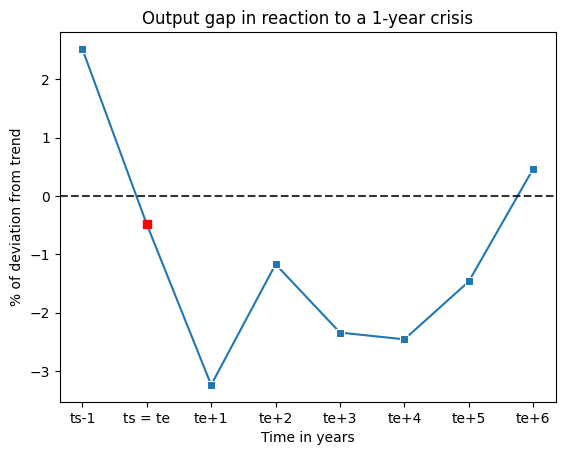

1


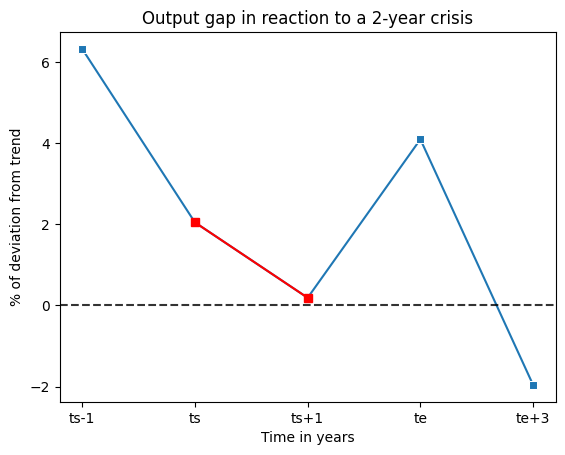

1


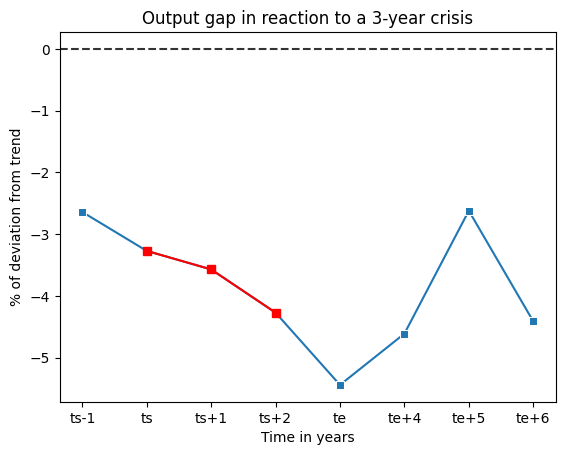

1


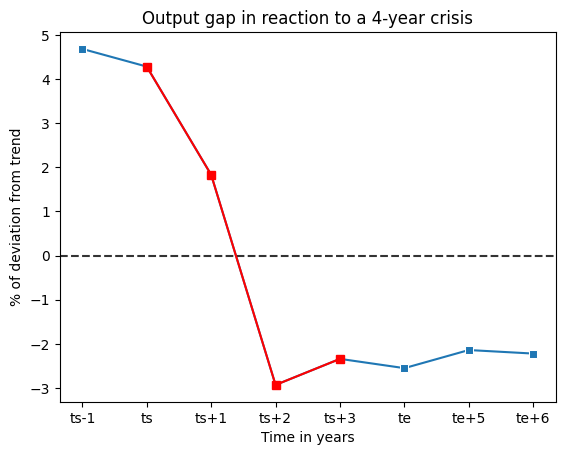

1


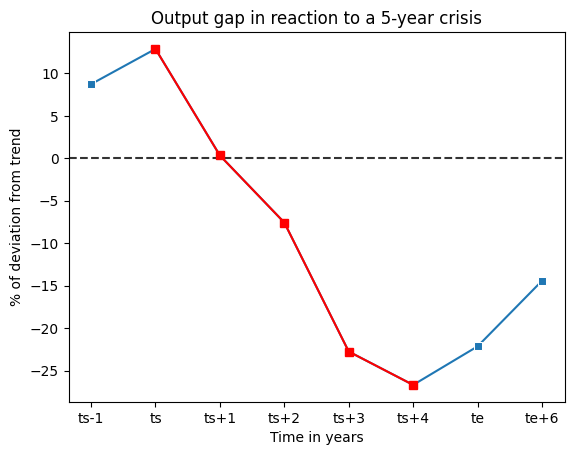

1


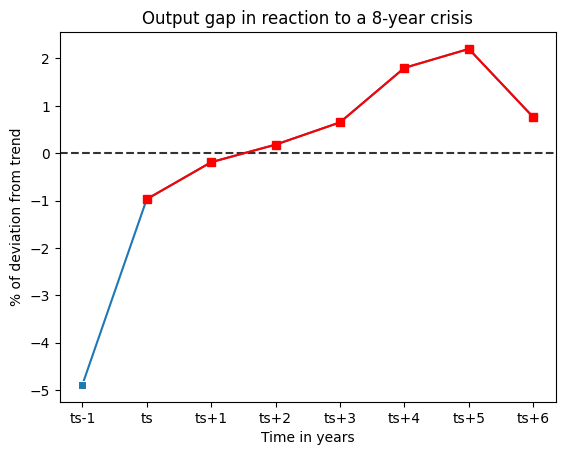

In [924]:
for i in len_freq.Length:
    series_by_crisis_length = []
    #Appending the series for single year crisis
    for j in range (0,len(output_gap_series)):
        if crisis_duration[j] == i:
            series_by_crisis_length.append(output_gap_series[j])
    print(len(series_by_crisis_length))

    average_pattern = compute_pattern(series_by_crisis_length)
    # confidence_interval = 1.96 * np.std(series_by_crisis_length, axis=0) / np.sqrt(series_by_crisis_length.shape[0])

    if i == 1:
        years = [f"ts{k}" if k < 0
                 else f"te+{k}" if k > 0
                 else "ts = te"
                 for k in range(-1, len(average_pattern) - 1)]
    else:
        years = [f"ts{k}" if k < 0
                 else f"ts" if k == 0
                 else f"ts+{k}" if 0 < k < i
                 else "te" if k == i
                 else f"te+{k}"
                 for k in range(-1, len(average_pattern) - 1)]

    # plt.fill_between(
    #     range(len(average_pattern)),
    #     average_pattern - confidence_interval,
    #     average_pattern + confidence_interval,
    #     color='blue',
    #     alpha=0.1, label='95% CI'
    # )

    sns.lineplot(x = years, y = average_pattern, marker = 's')
    plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.8)

    plt.plot(years[1:1+i], average_pattern[1:1+i], marker='s', color='red')  # Change marker color to red for example

    plt.title(f'Output gap in reaction to a {i}-year crisis')

    plt.xlabel('Time in years')
    plt.ylabel('% of deviation from trend')
    # plt.ylim(-7.5,7.5)

    plt.show()

# 4. Crisis & recovery Dynamics in a multiple country database

In [925]:
def crisis_data(data, during_crisis=True):

    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''

    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['annual_inflation']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis_only'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'annual_inflation'])
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['recovery_only'] == 1:
                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['annual_inflation'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['annual_inflation'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

In [926]:
def extract_inflation_series(data):
    ''' We want here to return the series of the inflaion rate for each first year of crisis until an inflation crisis happen or another banking crisis occurs.'''
    series = []
    current_serie = []

    for index, row in data.iterrows():
        if not pd.isna(row['annual_inflation']):
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
            if row['banking_crisis_only_first_year'] == 1:
                # Extract data during a crisis
                if index - 1 >= 0:
                    current_serie.append(data.at[index - 1, 'annual_inflation'])
                current_serie.append(row['annual_inflation'])
                for i in range(1,7):
                    if data.at[index + i, 'inflation_crisis'] == 1 or pd.isna(data.at[index + i,'annual_inflation']):
                        # data.at[index + i, 'banking_crisis_only_first_year'] == 1 or
                        break
                    current_serie.append(data.at[index + i,'annual_inflation'])
                series.append(current_serie)
                current_serie = []
    return series

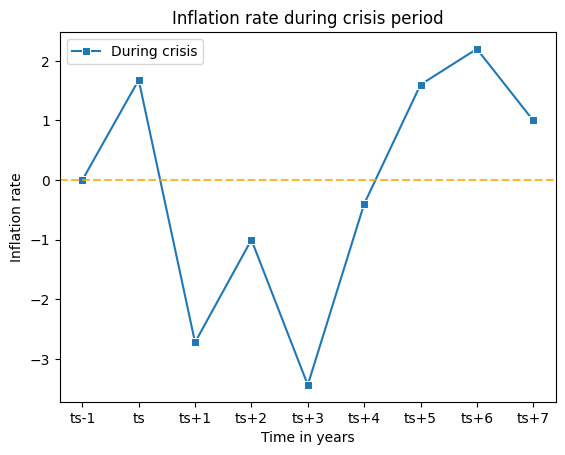

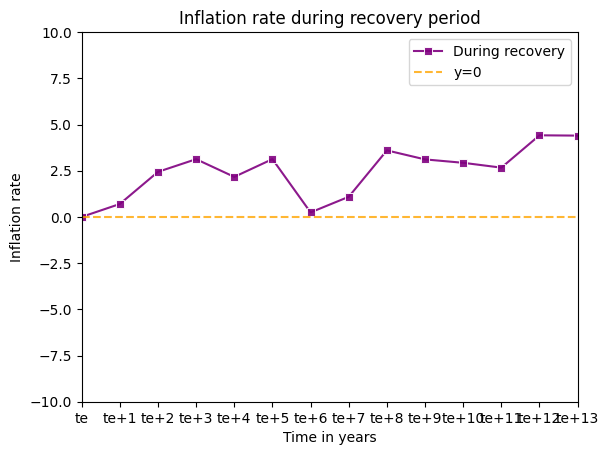

In [927]:
#Compute the average response pattern by time elapsed with normalizing the inflation series
pattern_during_crisis = compute_pattern(normalize_crisis_data(crisis_data(global_data, during_crisis = True)))
pattern_during_recovery = compute_pattern(normalize_crisis_data(crisis_data(global_data, during_crisis = False)))

#Compute the average response pattern by time elapsed without normalizing the inflation series
# pattern_during_crisis = compute_pattern(crisis_data(global_data, during_crisis = True))
# pattern_during_recovery = compute_pattern(crisis_data(global_data, during_crisis = False))

#Plot the inflation rate during banking crsis period
years = [f"ts{i}" if i < 0 else f"ts+{i}" if i > 0 else "ts" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'During crisis')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Inflation rate during crisis period')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')

plt.show()

#Plot the inflation rate during recovery period
years = [f"te+{i}" if i > 0 else "te" for i in range(0, len(pattern_during_recovery))]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'During recovery')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Inflation rate during recovery period')

plt.xlabel('Time in years')
plt.ylabel('Inflation rate')
plt.ylim(-10, 10)
plt.xlim('te', 'te+13')
plt.legend()

plt.show()

In [928]:
def output_crisis_data(data, during_crisis=True):
    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''
    series = []
    crisis_started = False
    no_crisis_period = False
    current_serie = []

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['output_gap']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis_only'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        # Append the inflation rate for the year before the crisis
                        if index - 1 >= 0:
                            current_serie.append(data.at[index - 1, 'output_gap'])
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    series.append(current_serie)
                    current_serie = []
            else:
                # Extract data during a non-crisis period
                if row['recovery_only'] == 1:

                    if not no_crisis_period:
                        no_crisis_period = True
                        # Append the inflation rate for the current year
                        current_serie.append(row['output_gap'])
                    else:
                        # Continue the existing series
                        current_serie.append(row['output_gap'])
                elif no_crisis_period:
                    # End the series when a 0 is recorded in the banking_crisis column
                    no_crisis_period = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
    # if not during_crisis:
    #     series = series[1:]
    return series

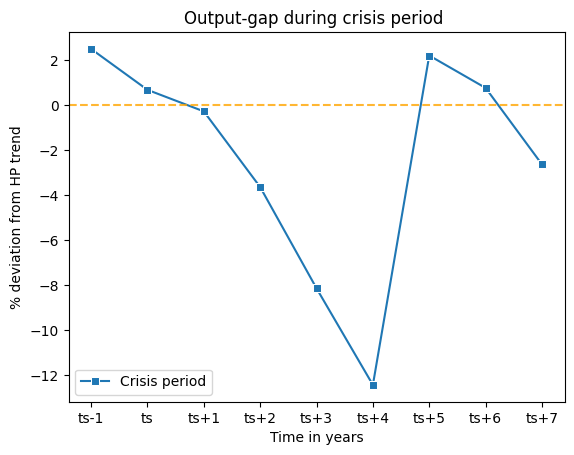

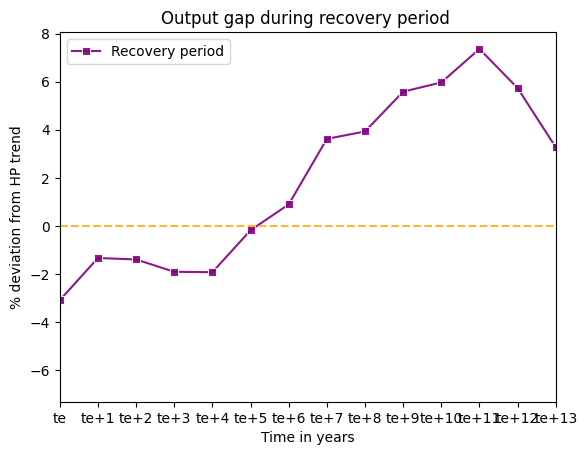

In [929]:
pattern_during_crisis = compute_pattern(output_crisis_data(global_data_inner, during_crisis = True))
pattern_during_recovery = compute_pattern(output_crisis_data(global_data_inner, during_crisis = False))

years = [f"ts{i}" if i < 0 else f"ts+{i}" if i > 0 else "ts" for i in range(-1, len(pattern_during_crisis) - 1)]
sns.lineplot(x = years, y = pattern_during_crisis, marker = 's', label = 'Crisis period')

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Output-gap during crisis period ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')

plt.show()

years = [f"te+{i}" if i > 0 else "te" for i in range(0, len(pattern_during_recovery))]
sns.lineplot(x = years, y = pattern_during_recovery, marker = 's', color = 'Purple', alpha = 0.9, label = 'Recovery period')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Output gap during recovery period ')

plt.xlabel('Time in years')
plt.ylabel('% deviation from HP trend')
plt.xlim('te', 'te+13')

plt.show()